In [2]:
from pyspark.sql import SparkSession

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("seaborn")
sc.install_pypi_package("tabulate")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/25/47/22fc373440e144e2111363adaa07abb09ec1f03fbc071b6d9fc0bbf65f68/pandas-1.1.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/bc/45/5118a05b0d61173e6eb12bc5804f0fbb6f196adb0a20e0b16efc2b8e98be/seaborn-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fa/cf/94686c3e2b21cba82904a2bbb014f7529d483021802a0116c3a256b00563/scipy-1.5.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/87/a6/8d7d06f6b69236a3c1818157875ceb1259ba0d9df4194f4fe138ffdc0f41/matplotlib-3.3.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5e/c4/6c4fe722df5343c33226f0b4e0bb042e4dc13483228b4718baf286f86d87/certifi-2020.6.20-py2.py3-none-any.whl
  Using cach

In [4]:
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import Row
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
in_bucket = "s3://tfmbigdata/Files_Segunda_Entrega/Products.json"
products = spark.read.format("json").load(in_bucket)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
products.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+-------------------+--------------------+--------------------+--------------------------+--------------+--------------------+----------------+--------------------+---------+------------+--------------------+-----------------+--------------+-------+-------------+
|agelimit|             article|       categoryname|          familyname|      hwgdescription|internationalarticlenumber|isocountrycode|   merchandisefamily|merchandisegroup| merchandisesubgroup|productid|scaleproduct|         sectionname|  subcategoryname|vatdescription|vatrate|weightproduct|
+--------+--------------------+-------------------+--------------------+--------------------+--------------------------+--------------+--------------------+----------------+--------------------+---------+------------+--------------------+-----------------+--------------+-------+-------------+
|  Keines|Lay's Al punto de...|             SNACKS|    PATATAS Y SNACKS|Pan/Bollería/Golo...|                      nul

In [7]:
rows_count = products.count()
columns = len(products.columns)

print("Rows: ",rows_count,"\nColumns: ", columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Rows:  7917 
Columns:  17

In [8]:
products = products.withColumn('scaleproduct', (products.scaleproduct).cast('integer'))
products = products.withColumn('weightproduct', (products.weightproduct).cast('integer'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
summary = products.summary()
missing_ratio = 1-(np.array(list(summary.filter(summary['summary'] == 'count').collect()[0].asDict().values())[1:], dtype=int))/rows_count
mr_row = spark.createDataFrame([['missing_ratio']+[float(x)*100 for x in missing_ratio]], summary.columns)
unique_row = products.agg(*(F.countDistinct(F.col(c)).alias(c) for c in products.columns)).withColumn('summary',F.lit('unique'))
summary = summary.unionByName(mr_row)
summary = summary.unionByName(unique_row)
summary_pd = summary.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
print(tabulate(summary_pd.set_index('summary').T, headers = 'keys', tablefmt = 'grid',showindex=True,floatfmt=".3f")) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------+---------+-------------+-------------+------------------------------------+-------------+-------------+-------------+-----------------------------------+-----------------+----------+
|                            |   count |        mean |      stddev | min                                |         25% |         50% |         75% | max                               |   missing_ratio |   unique |
+============================+=========+=============+=============+====================================+=============+=============+=============+===================================+=================+==========+
| agelimit                   |    7917 |      18.000 |       0.000 | 18                                 |      18.000 |      18.000 |      18.000 | Keines                            |           0.000 |        2 |
+----------------------------+---------+-------------+-------------+------------------------------------+-------------+-------------+-------------+-

# Categorías

In [11]:
products = products.withColumn('category', F.concat(F.col('merchandisegroup'),\
                                         F.lit(' - '), \
                                         F.col('merchandisesubgroup')))
#                                          F.col('merchandisesubgroup'),\
#                                          F.lit(' - '),\
#                                          F.col('merchandisefamily')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Cogemos los datos de la columna elegida y agregamos el count 
categories = products.select("category").groupBy("category").count()
categories_pd = categories.toPandas().sort_values(['category', 'count'],ascending=[1, 0])
print(categories_pd.count())
print(tabulate(categories_pd, headers = 'keys', tablefmt = 'grid',showindex=False,floatfmt=".3f")) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

category    42
count       42
dtype: int64
+----------------------------------------------------+---------+
| category                                           |   count |
+====================================================+=========+
| Carne - Ave Fresco                                 |      85 |
+----------------------------------------------------+---------+
| Carne - Carne Fresca                               |     165 |
+----------------------------------------------------+---------+
| Carne - Pescado Fresco                             |      70 |
+----------------------------------------------------+---------+
| Congelado - Congelados                             |     160 |
+----------------------------------------------------+---------+
| Food TS - Sonderverkauf Food                       |      10 |
+----------------------------------------------------+---------+
| Frischbrot / Hot Convenience - Bake off            |     222 |
+----------------------------------------------

In [13]:
categories_pd

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                             category  count
10                                 Carne - Ave Fresco     85
32                               Carne - Carne Fresca    165
33                             Carne - Pescado Fresco     70
22                             Congelado - Congelados    160
26                       Food TS - Sonderverkauf Food     10
1             Frischbrot / Hot Convenience - Bake off    222
28     Frischbrot / Hot Convenience - Hot Convenience      8
14                            Fruta y Verdura - Fruta    625
41                          Fruta y Verdura - Verdura    473
37                         Nevera - Delicatesen (nev)    136
38                        Nevera - Embutidos (Nevera)    160
6                               Nevera - Leche Fresca      4
12                               Nevera - Mantequilla      3
36                               Nevera - Mopro (nev)    196
25                               Nevera - Queso (nev)    219
19        Surtido seco -

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

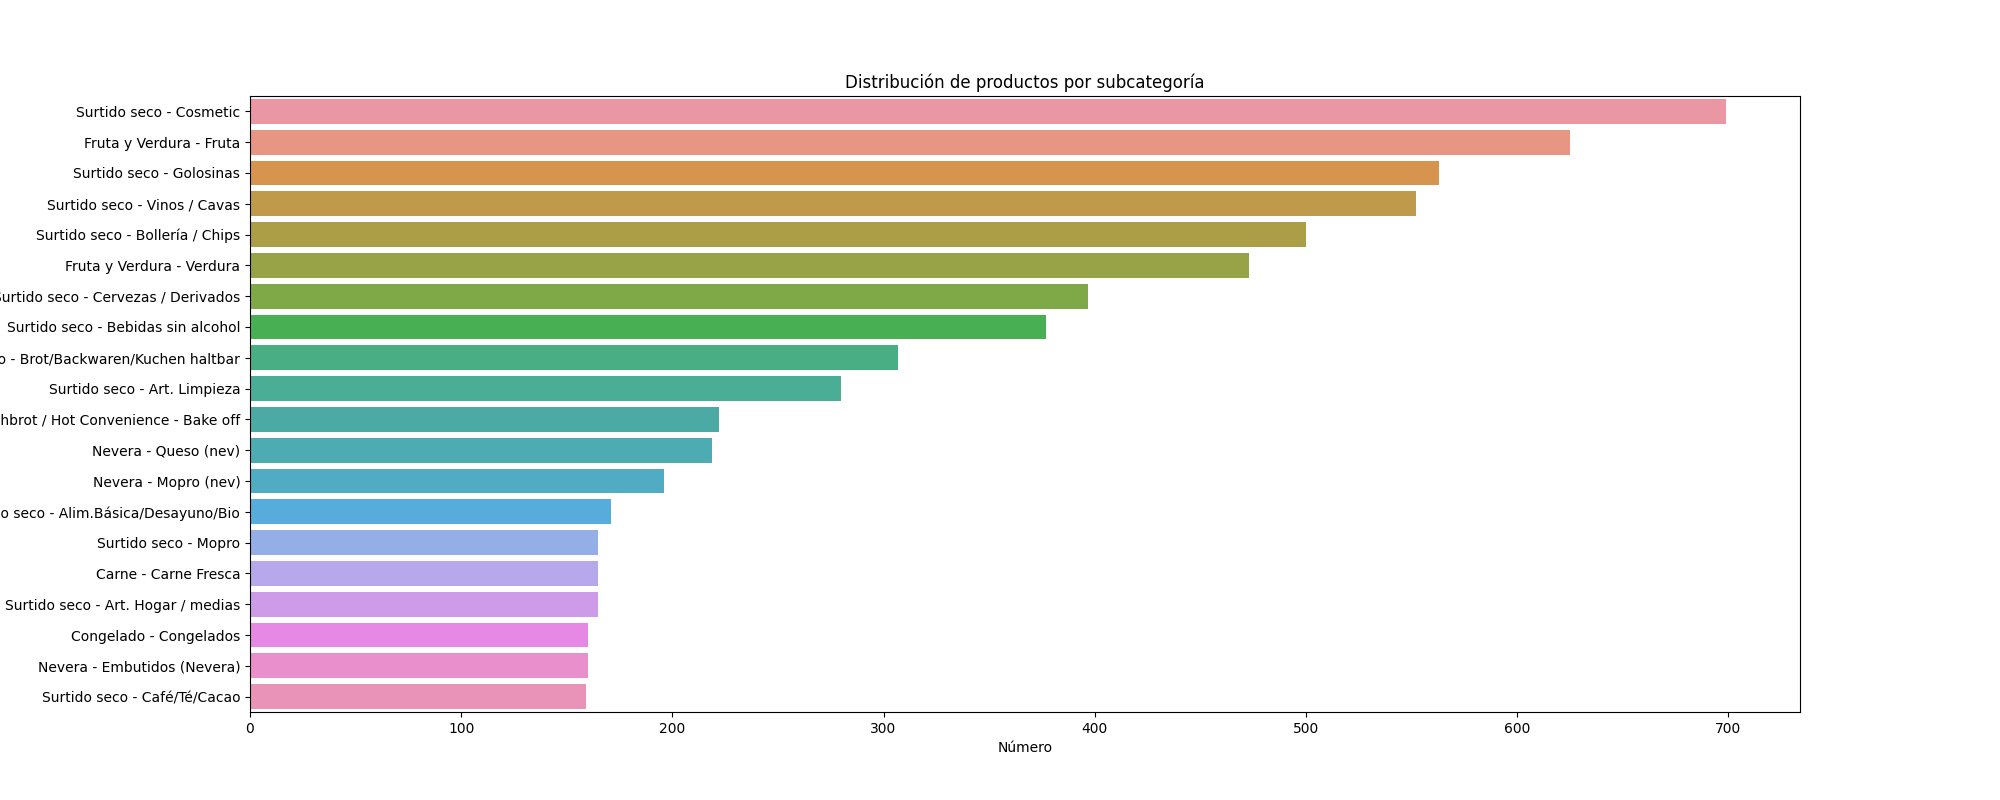

In [14]:
#Visualizamos
plt.clf()
plt.figure(figsize=(20,8))
splot = sns.barplot(y="category", x="count", data=categories_pd.sort_values('count',ascending=False).head(20))
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()+500), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 0), 
                   textcoords = 'offset points')
# splot.set_xticklabels(splot.get_xticklabels(), rotation=70)
splot.set_title('Distribución de productos por subcategoría')
plt.xlabel('Número')
# plt.yscale('logit')

%matplot plt

# Tipo de IVA

In [55]:
# Cogemos los datos de la columna elegida y agregamos el count 
vatdesc = products.select( F.concat(F.col("vatdescription"),\
                                    F.lit(' ('), \
                                    F.col('vatrate'),\
                                    F.lit(')')).alias('vatdescription')).groupBy("vatdescription").count()
vatdesc_pd = vatdesc.toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
print(vatdesc_pd.count())
print(tabulate(vatdesc_pd, headers = 'keys', tablefmt = 'grid',showindex=False,floatfmt=".3f")) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vatdescription    5
count             5
dtype: int64
+------------------------------+---------+
| vatdescription               |   count |
+==============================+=========+
| Ordinario (21.0)             |    2281 |
+------------------------------+---------+
| Superreducido (4.0)          |    1228 |
+------------------------------+---------+
| X_Antiguo - Ordinario (16.0) |       5 |
+------------------------------+---------+
| Cero (0.0)                   |     299 |
+------------------------------+---------+
| Reducido (10.0)              |    4104 |
+------------------------------+---------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

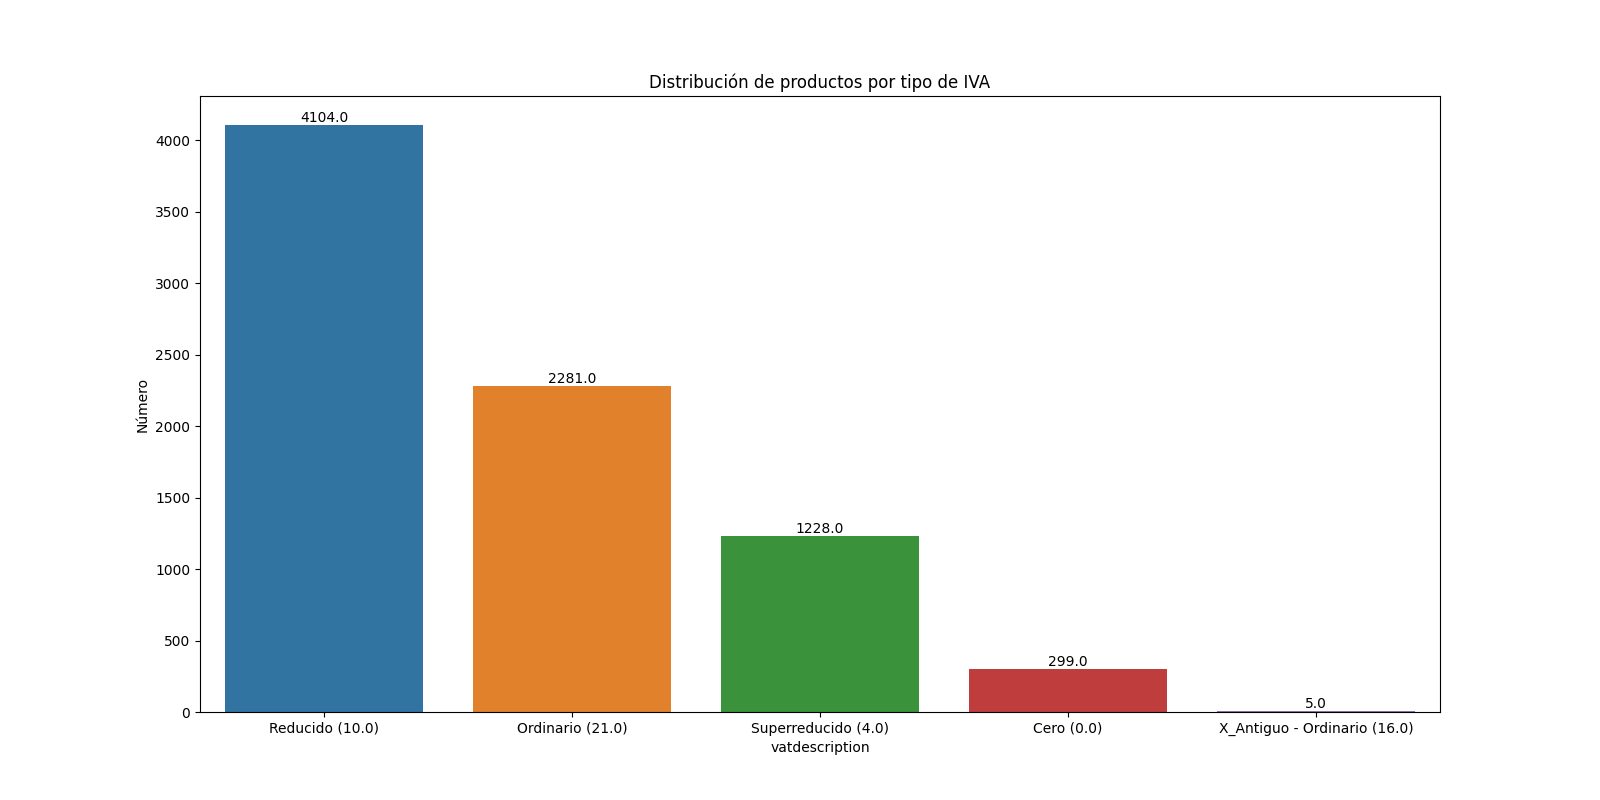

In [60]:
plt.clf()
plt.figure(figsize=(16,8))
splot = sns.barplot(x="vatdescription", y="count", data=vatdesc_pd.sort_values('count',ascending=False))
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()+50), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 0), 
                   textcoords = 'offset points')
# splot.set_xticklabels(splot.get_xticklabels(), rotation=70)
splot.set_title('Distribución de productos por tipo de IVA')
plt.ylabel('Número')
%matplot plt